# Combining gone fishing (BAIT) with Fisher mask (FISH)

Fisher mask code in FISH folder

In [1]:
import torch
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

print(torch.__version__, torchvision.__version__)

cuda
1.13.0 0.14.0


Next steps:

* download the dataset cifar10, and create a dataloader  with appropriate preprocessing
* iterate over minibatches from dataloader, calculate crossentropy loss, 
* in typical sgd training, we zero out the gradients before processing the next minibatch. this is done by calling model.zero_grad(), and then calling model.backward() to get the new gradients. Since we are not interested in training right now, we want the sum of gradients over all minibatches. so we should not call model.zero_grad()
* identify the top 2% of all the weights in the model and make a new pk x k array, where p = 2% of the total number of parameters.

In [2]:
from torchvision.models import resnet18, ResNet18_Weights

# Using pretrained weights:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
preprocess = ResNet18_Weights.DEFAULT.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
type(preprocess)

torchvision.transforms._presets.ImageClassification

In [3]:
import torchvision.datasets as datasets

processed_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 <class 'torch.Tensor'>


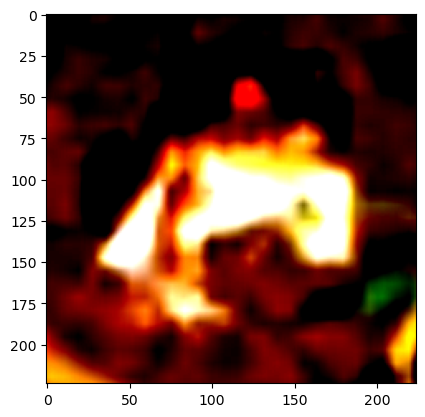

In [6]:
import matplotlib.pyplot as plt
import numpy as np

img, label = processed_trainset[0]
print(label, type(img))
im = img.permute(1, 2, 0) # https://stackoverflow.com/a/55196345
plt.imshow(im)
plt.show()

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 <class 'torch.Tensor'>


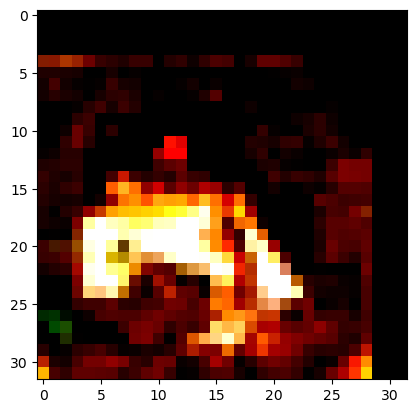

In [8]:
import torchvision.transforms as transforms

transform_from_run = transforms.Compose([ 
                     transforms.RandomCrop(32, padding=4),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor(),
                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                 ])
new_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_from_run)
img, label = new_cifar[0]
print(label, type(img))
im = img.permute(1, 2, 0) # https://stackoverflow.com/a/55196345
plt.imshow(im)
plt.show()

In [7]:
trainloader = torch.utils.data.DataLoader(processed_trainset, batch_size=128, num_workers=1)

In [8]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

the above pretrained model is for imagenet, which has 1000 classes. We want to use it for 10 class cifar, so we have to change the model, by reducing number of neurons in last layer from 1000 to 10. We should train this modified model for a few epochs while keeping all the previous weights fixed (frozen layers/weights) 

building off the tutorial at https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

Files already downloaded and verified


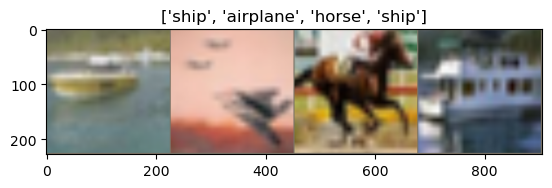

In [4]:
import time
import copy
import matplotlib.pyplot as plt
import numpy as np

class_names = processed_trainset.classes
processed_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
dataloaders = {'train' : [], 'val' : []}
dataloaders['train'] = torch.utils.data.DataLoader(processed_trainset, batch_size=128,
                                                    shuffle=True, num_workers=4, pin_memory=True)
dataloaders['val'] = torch.utils.data.DataLoader(processed_testset, batch_size=128,
                                                    shuffle=False, num_workers=4, pin_memory=True)
dataset_sizes = {'train' : len(processed_trainset), 'val' : len(processed_testset)}


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # same as in preprocess
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [5]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# freeze all pretrained weights 
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer_conv,
                    exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.2345 Acc: 0.6280
val Loss: 0.8932 Acc: 0.7190

Epoch 1/4
----------
train Loss: 0.8317 Acc: 0.7343
val Loss: 0.7825 Acc: 0.7473

Epoch 2/4
----------
train Loss: 0.7563 Acc: 0.7501
val Loss: 0.7370 Acc: 0.7576

Epoch 3/4
----------
train Loss: 0.7188 Acc: 0.7601
val Loss: 0.7086 Acc: 0.7641

Epoch 4/4
----------
train Loss: 0.6941 Acc: 0.7667
val Loss: 0.6926 Acc: 0.7688

Training complete in 2m 44s
Best val Acc: 0.768800


above just trains the weights in the last layer. we can compare the preformance above with finetuning, i.e., training all the weights in the network.

Also, the high train loss suggests that I could do better with tuning hyperparams

In [7]:
model_to_finetune = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model_to_finetune.fc.in_features
model_to_finetune.fc = nn.Linear(num_ftrs, len(class_names))
model_to_finetune.to(device)
optimizer = optim.SGD(model_to_finetune.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_to_finetune = train_model(model_to_finetune, criterion, optimizer,
                                scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2391 Acc: 0.6221
val Loss: 0.9023 Acc: 0.7181

Epoch 1/24
----------
train Loss: 0.8296 Acc: 0.7367
val Loss: 0.7834 Acc: 0.7462

Epoch 2/24
----------
train Loss: 0.7558 Acc: 0.7508
val Loss: 0.7378 Acc: 0.7568

Epoch 3/24
----------
train Loss: 0.7198 Acc: 0.7590
val Loss: 0.7119 Acc: 0.7643

Epoch 4/24
----------
train Loss: 0.6972 Acc: 0.7646
val Loss: 0.6970 Acc: 0.7670

Epoch 5/24
----------
train Loss: 0.6790 Acc: 0.7701
val Loss: 0.6821 Acc: 0.7692

Epoch 6/24
----------
train Loss: 0.6677 Acc: 0.7751
val Loss: 0.6728 Acc: 0.7726

Epoch 7/24
----------
train Loss: 0.6569 Acc: 0.7765
val Loss: 0.6695 Acc: 0.7746

Epoch 8/24
----------
train Loss: 0.6587 Acc: 0.7758
val Loss: 0.6728 Acc: 0.7729

Epoch 9/24
----------
train Loss: 0.6565 Acc: 0.7762
val Loss: 0.6700 Acc: 0.7739

Epoch 10/24
----------
train Loss: 0.6569 Acc: 0.7771
val Loss: 0.6698 Acc: 0.7758

Epoch 11/24
----------
train Loss: 0.6509 Acc: 0.7789
val Loss: 0.6696 Acc: 0.7746

Ep

I can identify the "important" weights, which as per the FISH paper, are those with large values of $\frac{1}{N} \sum_{i=1}^{N} \mathbb{E}_{y \sim p_\theta (y\mid x_i)} (\nabla_\theta \log p_\theta (y \mid x_i))^2$, the square is componentwise 

In [6]:
import torch.nn.functional as F

test_batch, test_labels = next(iter(dataloaders['val']))
outputs = model(test_batch.to(device))
_, preds = torch.max(outputs, 1)
torch.sum(preds == test_labels.to(device).data) / len(test_labels) 
# 25 epochs --> 0.8203, 
# 5 epochs --> 0.7891

tensor(0.7891, device='cuda:0')

In [7]:
for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) False
bn1.weight torch.Size([64]) False
bn1.bias torch.Size([64]) False
layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn1.weight torch.Size([64]) False
layer1.0.bn1.bias torch.Size([64]) False
layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn2.weight torch.Size([64]) False
layer1.0.bn2.bias torch.Size([64]) False
layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn1.weight torch.Size([64]) False
layer1.1.bn1.bias torch.Size([64]) False
layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn2.weight torch.Size([64]) False
layer1.1.bn2.bias torch.Size([64]) False
layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) False
layer2.0.bn1.weight torch.Size([128]) False
layer2.0.bn1.bias torch.Size([128]) False
layer2.0.conv2.weight torch.Size([128, 128, 3, 3]) False
layer2.0.bn2.weight torch.Size([128]) False
layer2.0.bn2.bias torch.Size([128]) False
layer2.0.downsample.0.weight torch.Size([128, 64

In [18]:
log_probs = F.log_softmax(outputs, dim=1)
log_probs[0, 3].backward()

In [24]:
print(model.fc.weight.grad.shape, model.fc.bias.grad.shape)
# print(model.layer4[1].bn2.weight.grad.shape)
print(model.conv1.weight.grad.shape)

torch.Size([10, 512]) torch.Size([10])


AttributeError: 'NoneType' object has no attribute 'shape'

In [27]:
for param in model.parameters():
    param.requires_grad = True

model.zero_grad()
outputs = model(test_batch.to(device))
log_probs = F.log_softmax(outputs, dim=1)
log_probs[0, 3].backward()
print(model.fc.weight.grad.shape, model.fc.bias.grad.shape)
print(model.conv1.weight.grad.shape)

torch.Size([10, 512]) torch.Size([10])
torch.Size([64, 3, 7, 7])


In [29]:
# following https://github.com/pytorch/pytorch/issues/49171#issuecomment-934055267

for param in model.parameters():
    param.requires_grad = True

model.zero_grad()
outputs = model(test_batch.to(device))
prob = F.softmax(outputs, dim=1).unsqueeze(-1).unsqueeze(-1)
log_probs = F.log_softmax(outputs, dim=1)
N, C = log_probs.shape


parameters = tuple(model.parameters())
fim_dict = {i: [] for i in range(len(parameters))}

for n in range(N):
    for c in range(C):
        grad_list = torch.autograd.grad(log_probs[n][c], parameters, retain_graph=True)
        for i, grad in enumerate(grad_list):    # different layers
            flatten_grad = grad.flatten()    # (D)
            fim = flatten_grad.unsqueeze(1) * flatten_grad.unsqueeze(0)   # (D, D)
            fim_dict[i].append(fim.detach().clone())

fim_list = []
for i, value in fim_dict.items():    # different layers
    D = value[0].shape[0]
    grad = torch.stack(value).view(N, C, D, D) * prob    # (N, C, D, D)
    fim_list.append(grad.sum(1).mean(0))

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.06 GiB (GPU 0; 15.74 GiB total capacity; 8.17 GiB already allocated; 3.64 GiB free; 9.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [30]:
# save the model to memory
torch.save(model.state_dict(), 'resnet18_feats_cifar10.pyt')

## Resume from stored model

In [1]:
import torch
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

print(torch.__version__, torchvision.__version__)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10) # cifar10
model.load_state_dict(torch.load('resnet18_feats_cifar10.pyt'))
model = model.to(device)
preprocess = ResNet18_Weights.DEFAULT.transforms()
processed_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(processed_testset, batch_size=128,
                                            shuffle=False, num_workers=4)

test_batch, test_labels = next(iter(testloader))
outputs = model(test_batch.to(device))
_, preds = torch.max(outputs, 1)
torch.sum(preds == test_labels.to(device).data) / len(test_labels) # 0.7891? possibly because model has to be in eval mode

cuda
1.13.0 0.14.0
Files already downloaded and verified


tensor(0.7734, device='cuda:0')

In [2]:
prob = F.softmax(outputs, dim=1).unsqueeze(-1).unsqueeze(-1)
log_probs = F.log_softmax(outputs, dim=1)
N, C = log_probs.shape

parameters = tuple(model.parameters())
gsq_dict = {i: [] for i in range(len(parameters))}

for n in range(N):
    for c in range(C):
        grad_list = torch.autograd.grad(log_probs[n][c], parameters, retain_graph=True)
        for i, grad in enumerate(grad_list):    # different layers
            flatten_grad = grad.flatten()
            gsq = torch.square(flatten_grad)
            gsq_dict[i].append(gsq.detach().clone())
    print(n)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 15.74 GiB total capacity; 9.23 GiB already allocated; 325.25 MiB free; 9.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [37]:
trainloader = torch.utils.data.DataLoader(processed_trainset, batch_size=128, shuffle=True, num_workers=2)

it_trainloader = iter(trainloader) #https://discuss.pytorch.org/t/iterating-through-a-dataloader-object/25437/2

first_imgs, first_lbls = next(it_trainloader)
second_imgs, secong_lbls = next(it_trainloader)

criterion = torch.nn.CrossEntropyLoss()

model = model.to(device)
first_outs = model(first_imgs.to(device))
loss = criterion(first_outs.to(device), first_lbls.to(device))
loss.backward()
first_grads = model.conv1.weight.grad.to('cpu').numpy()
type(first_grads)

numpy.ndarray

In [38]:
second_outs = model(second_imgs.to(device))
loss = criterion(second_outs.to(device), secong_lbls.to(device))
loss.backward()
first_and_second_grads = model.conv1.weight.grad.to('cpu').numpy()

In [39]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model = model.eval()
model = model.to(device)
second_outs = model(second_imgs.to(device))
loss = criterion(second_outs.to(device), secong_lbls.to(device))
loss.backward()
second_grads = model.conv1.weight.grad.to('cpu').numpy()

In [52]:
np.allclose(first_and_second_grads, first_grads + second_grads, atol=1e-5)

True

the first and second gradients got added up when loss.backward() was called twice

So let us run over the entire dataset

In [53]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model = model.eval()
model = model.to(device)

trainloader = torch.utils.data.DataLoader(processed_trainset, batch_size=128, shuffle=True, num_workers=2)

for batch_idx, (inputs, targets) in enumerate(trainloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    if batch_idx % 10 == 0: print(batch_idx)


In [ ]:
# for loop over named parameters, concatenate all the grads in a flattened array, plot the histogram

to apply BAIT, we need the Fisher information matrix, which is the expected hessian of the loss wrt the important weights

In [45]:
first_and_second_grads[0, 0, 0, 0]

-0.37977585

In [44]:
first_grads[0, 0, 0, 0]

-0.24314049

In [47]:
second_grads[0,0,0,0] + first_grads[0, 0, 0, 0]

-0.3797757

# Scratch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 <class 'PIL.Image.Image'>


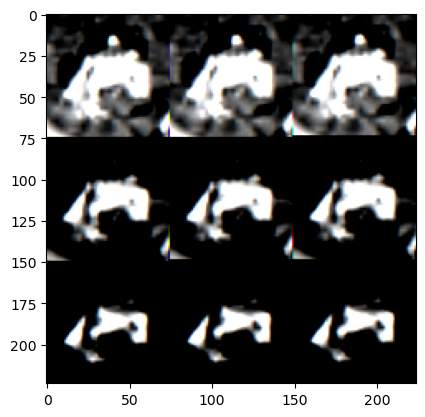

In [9]:
img, label = vanilla_trainset[0]
print(label, type(img))
im = np.array(preprocess(img)).reshape((224, 224, 3))
plt.imshow(im)
plt.show()

6 <class 'PIL.Image.Image'>


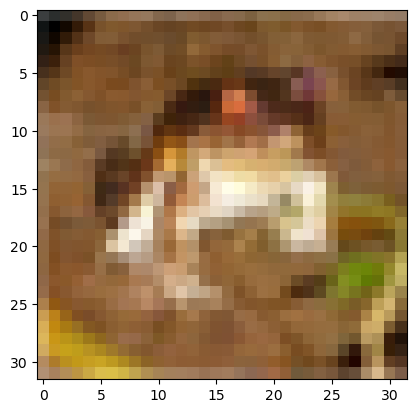

In [10]:
img, label = vanilla_trainset[0]
print(label, type(img))
im = np.array(img).reshape((32, 32, 3))
plt.imshow(im)
plt.show()

In [11]:
img = preprocess(vanilla_trainset[0][0])
print(type(img), img.shape)

<class 'torch.Tensor'> torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


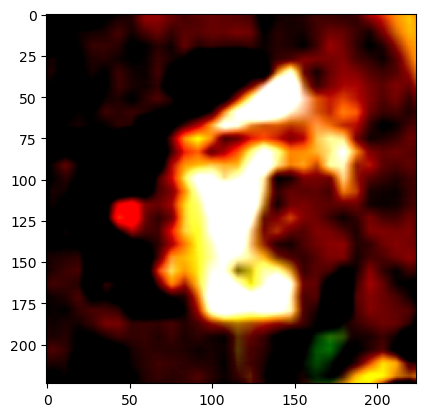

In [18]:
plt.imshow(torch.transpose(img, 0, 2))

In [24]:
import torchvision.transforms as transforms

cifar_args = {'n_epoch': 3, 'transform': transforms.Compose([ 
                     transforms.RandomCrop(32, padding=4),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor(),
                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                 ]),
                 'loader_tr_args':{'batch_size': 128, 'num_workers': 1},
                 'loader_te_args':{'batch_size': 1000, 'num_workers': 1},
                 'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
                 'transformTest': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
            }
cifar_trainset2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_args['transform'])
cifar_trainloader2 = torch.utils.data.DataLoader(cifar_trainset, batch_size=cifar_args['loader_tr_args']['batch_size'], num_workers=cifar_args['loader_tr_args']['num_workers'], shuffle=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


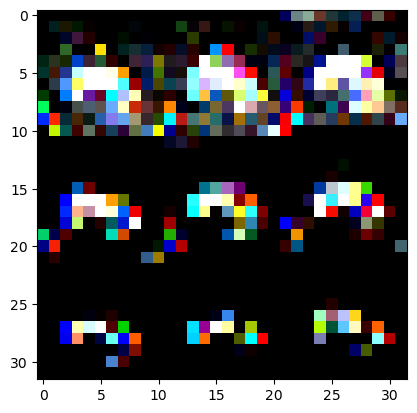

In [46]:
img, label = cifar_trainset2[0]
print(label)
plt.imshow(img.squeeze().reshape((32, 32, -1)))
plt.show()

In [45]:
img = np.array(img)
img.shape

(3, 32, 32)

In [13]:
cifar3 = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


In [14]:
import numpy as np
im = np.array(cifar3[0][0])
im.shape

(32, 32, 3)

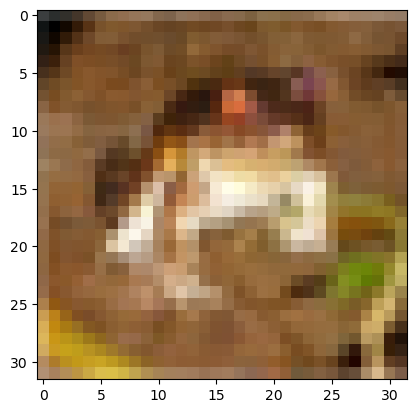

In [15]:
plt.imshow(im)


In [39]:
img, label = cifar_trainset[0]
im = np.array(img)
im.shape

(3, 224, 224)

In [16]:
img = preprocess(cifar3[0][0])
print(type(img), img.shape)

<class 'torch.Tensor'> torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


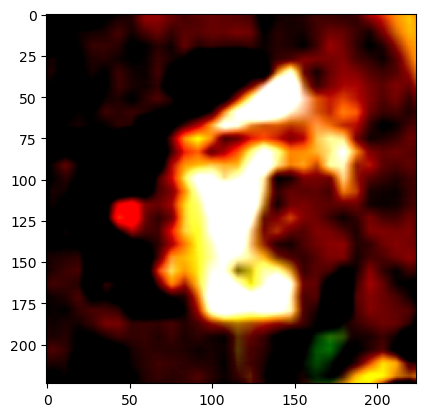

In [17]:
plt.imshow(torch.transpose(img, 0, 2))